# P1-Conservative interpolation on unstructured meshes

## Description

Implementation of a P1-conservative interpolation scheme for triangular meshes. Adapted from Alauzet and Mehrenberger (2010).

Implementation is based on xugrid (https://deltares.github.io/xugrid/api.html).

Source codes developped for interfacing with Elmer, interpolation (mesh2mesh interpolation) and projection (element to node and vice versa) are under the directory **ElmerUgrid**

2 sequences of meshes mesh_Ai and mesh_Bi have been produced in Elmer format (see [MakeMeshSequence.sh](../DATA/MakeMeshSequence.sh) to produce the meshes).

Implementation of the  Alauzet and Mehrenberger's test cases:   
- **6.1. A Gaussian function**
- **6.2. A continuous sinusoidal shock**

The algorithm is:   
1. Conservatively interpolate values defined at the nodes of the source grid to a a varaible defined at the elements of the target grid. This is done by integrating the shape functions over the intersection between the target and source grids.
2. Compute the gradient of the variable as an element variable and conservatively interpolate the gradient for the source elements to the target elements.
3. Project the results to the nodes applying min/max.
4. Average nodal values between the target elements that own the nodes.

Everything can be done in one step using the function **node_2_node_interpolation**.

Reminder: the algorithm is conservative for matching boundaries. If the boundaries do not match, the values must be  extrapolated somehow. For the moment, the conservative interpolation is normalised using the intersection area; i.e. for example if a variable is constant in the source element that overleps only a fraction of a traget element, the result will be constant over the target element.

References:   
- Alauzet and Mehrenberger, P1-conservative solution interpolation on unstructured triangular meshes, Int. J. Numer. Meth. Engng., 2010

In [1]:
import xugrid as xu
import xarray as xr
import numpy as np
from scipy.sparse import *
from numba_celltree.celltree import(cast_vertices, cast_faces)

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

In [2]:
sys.path.insert(0, os.path.abspath('../'))

from ElmerUgrid import ugrid
from ElmerUgrid.Interpolation import *
from ElmerUgrid.Projection import *

from ElmerUgrid.fem import ComputeGrad,TriIntegrate

## The main function of the P1 interpolation:
print(node_2_node_interpolation.__doc__)

## For bi-linear interpolation see:
print(barycentric_interpolator.__doc__)


    node_2_node_interpolation(source,target,Bounded,area_threshold):
        
        P1-conservative interpolation on unstructured triangular meshes
        Adapted from Alauzet and Mehrenberger, Int. J. Numer. Meth. Engng., 2010
        The mesh intersection is adapetd from :
         - xugrid: https://github.com/Deltares/xugrid 
         - numba_celltree tree: https://github.com/Deltares/numba_celltree

        Parameters:
                source (xugrid.UgridDataArray): source data to interpolate
                target (xu.Ugrid2d): the target mesh
                Bounded (bool): if True apply the minmax
                area_threshold=1.0e-3: if the ratio of the intersection area with the target element area 
                    is less than the threshold the value in the target elment is set to nan
                    
        Returns:
                result (xu.UgridDataArray): the source interpolated on the target mesh


        TODO: 
            - For non-matching boundaries, 

## Test case definition

### A Gaussian function

In [3]:
def u1(grid):
    nodes=grid.node_coordinates
    u=np.exp(-30.0*(nodes[:,0]*nodes[:,0]+nodes[:,1]*nodes[:,1]))
    
    da = xr.DataArray(
    data=u,
    name="u1",
    dims=[grid.node_dimension],
    attrs=dict(mesh=grid.name,location="node"))
    
    da = xu.UgridDataArray(da, grid)

    return da


def u1f(grid):
    # face center coordinates
    facesx=grid.face_coordinates
    u=np.exp(-30.0*(facesx[:,0]*facesx[:,0]+facesx[:,1]*facesx[:,1]))
    
    da = xr.DataArray(
    data=u,
    name="u1f",
    dims=[grid.face_dimension],
    attrs=dict(mesh=grid.name,location="face"))
    
    da = xu.UgridDataArray(da, grid)

    return da   



### A continuous sinusoidal shock

In [4]:
def u2(grid):
    nodes=grid.node_coordinates
    u=np.tanh(100.0*(nodes[:,1]+0.3*np.sin(-2.0*nodes[:,0])))
    
    da = xr.DataArray(
    data=u,
    name="u1",
    dims=[grid.node_dimension],
    attrs=dict(mesh=grid.name,location="node"))
    
    da = xu.UgridDataArray(da, grid)

    return da


def u2f(grid):
    # face center coordinates
    facesx=grid.face_coordinates
    u=np.tanh(100.0*(facesx[:,1]+0.3*np.sin(-2.0*facesx[:,0])))
    
    da = xr.DataArray(
    data=u,
    name="u1f",
    dims=[grid.face_dimension],
    attrs=dict(mesh=grid.name,location="face"))
    
    da = xu.UgridDataArray(da, grid)

    return da   

### Get meshes

In [5]:
DATA_DIR="../DATA"

##The mesh number
# there is 5 meshes increasingly refined
case=2

- Source mesh

number of nodes in mesh2d 2613


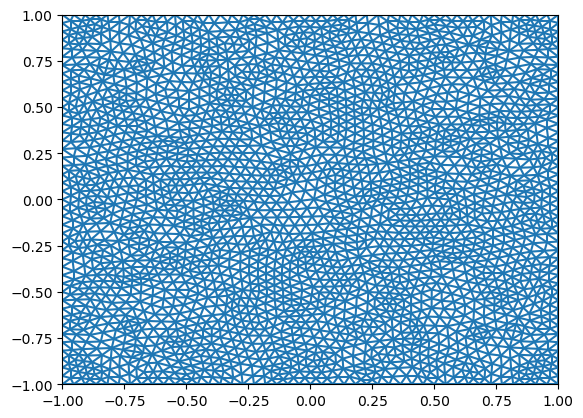

In [6]:
mesh_name="squareA%s"%(str(case))
mesh_name=os.path.join(DATA_DIR, mesh_name)

A_grid=xu.Ugrid2d.FromElmer(mesh_name)
print("number of nodes in %s %i"%(A_grid.name,A_grid.n_node))

A_grid.plot()

- Target mesh

number of nodes in mesh2d 2321


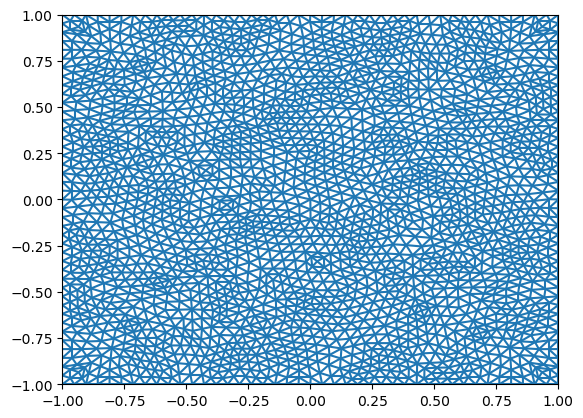

In [7]:
mesh_name="squareB%s"%(str(case))
mesh_name=os.path.join(DATA_DIR, mesh_name)

B_grid=xu.Ugrid2d.FromElmer(mesh_name)
print("number of nodes in %s %i"%(B_grid.name,B_grid.n_node))


B_grid.plot()

### Define solutions on the mesh

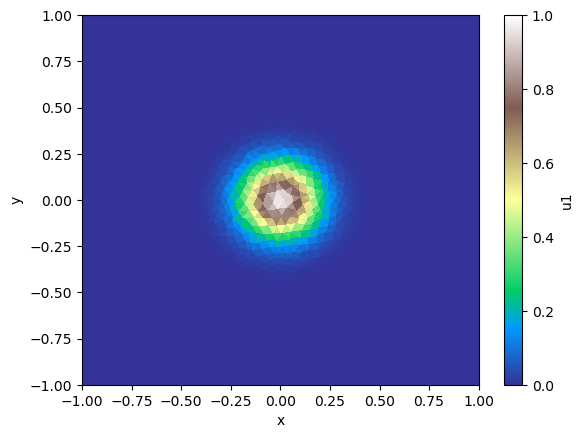

In [8]:
u_A_n=u1(A_grid)
u_A_n.ugrid.plot(vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))

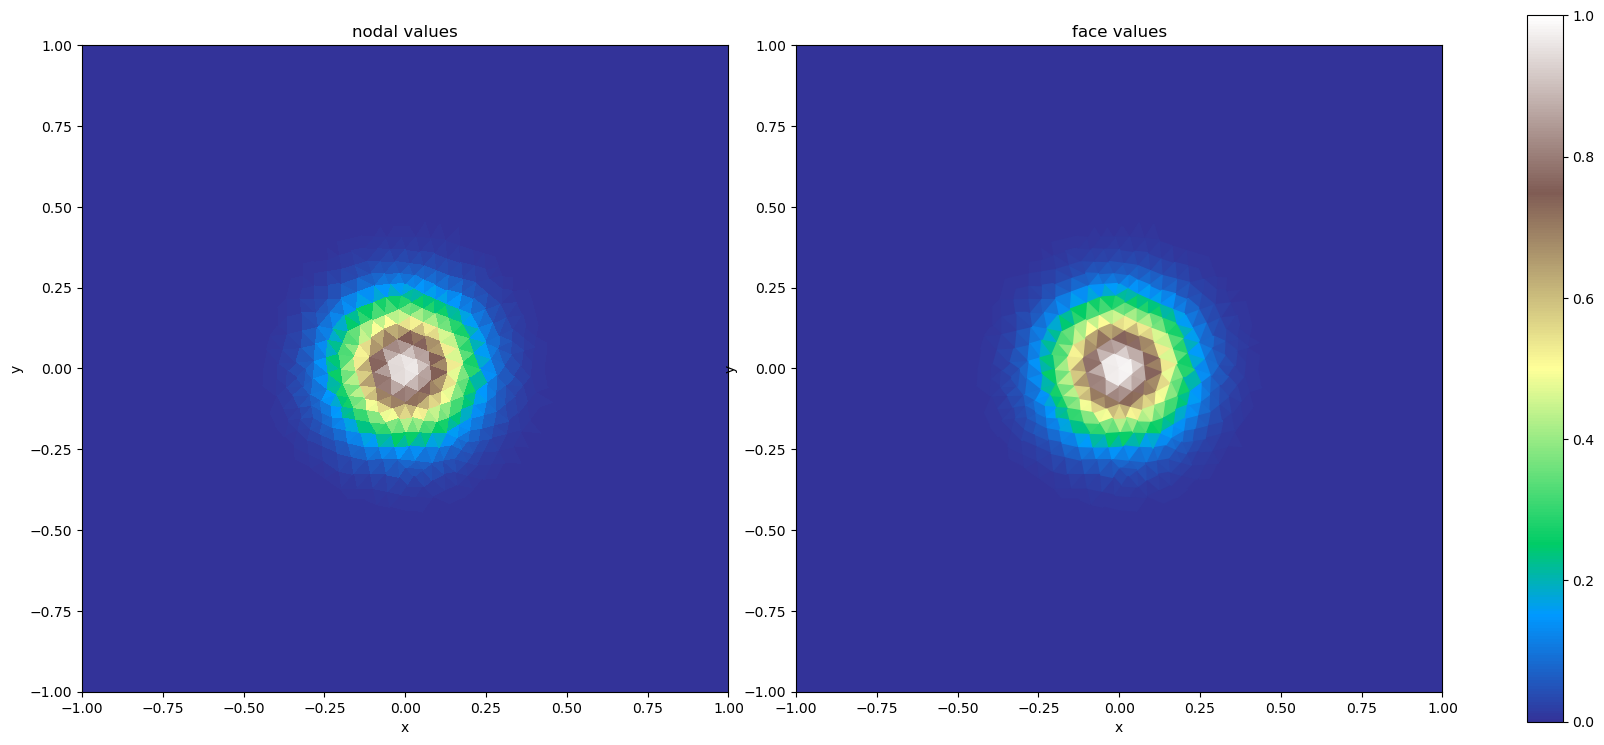

In [9]:
u_B_n=u1(B_grid)
u_B_f=u1f(B_grid)

# Plot unstructured grid and cross section
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))

im1=u_B_n.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0),add_colorbar=False)
im2=u_B_f.ugrid.plot(ax=ax1,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0),add_colorbar=False)

ax0.set_title("nodal values")
ax1.set_title("face values")
ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)
fig.tight_layout()

cb = fig.colorbar(im2, ax=(ax0, ax1), orientation='vertical')

## Step By Step interpolation

1. Compute gradient of the solution
   
   The solution is constant by element

In [10]:
ugrad_A_f=ComputeGrad(faces=A_grid.face_node_connectivity,
            vertices=A_grid.face_node_coordinates,
            values=u_A_n.values)

dudx_A_f = xr.DataArray(
    data=ugrad_A_f[:,0],
    name="dudx",
    dims=[A_grid.face_dimension],
    attrs=dict(mesh=A_grid.name,location="face"))

dudy_A_f = xr.DataArray(
    data=ugrad_A_f[:,1],
    name="dudy",
    dims=[A_grid.face_dimension],
    attrs=dict(mesh=A_grid.name,location="face"))
    
dudx_A_f = xu.UgridDataArray(dudx_A_f,A_grid)
dudy_A_f = xu.UgridDataArray(dudy_A_f, A_grid)

2. Conservative node 2 face interpolation

In [11]:
target_vertices=cast_vertices(B_grid.node_coordinates)
target_faces=cast_faces(B_grid.face_node_connectivity,B_grid.fill_value)

source_vertices=cast_vertices(A_grid.node_coordinates)
source_faces=cast_faces(A_grid.face_node_connectivity, A_grid.fill_value)

## Compute the intersection between source and target faces 
target_indices,source_indices=A_grid.celltree._locate_faces(target_vertices,target_faces)

## Interpolation weights from source nodal values to face target values
area,weights,source_node_index,target_face_index = node_2_face_interpolation(
            vertices_a=target_vertices,
            vertices_b=source_vertices,
            faces_a=target_faces,
            faces_b=source_faces,
            indices_a=target_indices,
            indices_b=source_indices,
        )

M = coo_matrix((weights,(target_face_index,source_node_index)), shape=(B_grid.n_face,A_grid.n_node) )
M=M.tocsr()


############################
### Compute MinMax to apply the maximuim principle
############################
MinMax=IntersectionMinMax(node_values=u_A_n.values,
                              target_faces= target_faces,
                              source_faces= source_faces,
                              target_indices= target_indices,
                              source_indices= source_indices,
                              area= area)

## Conservative face to face interpolation weights for the gradient
weights_f,target_face_index_f,source_face_index_f=face_2_face_interpolation(
            vertices_a=target_vertices,
            vertices_b=source_vertices,
            faces_a=target_faces,
            faces_b=source_faces,
            indices_a=target_indices,
            indices_b=source_indices,
        )


Mf = coo_matrix((weights_f,(target_face_index_f,source_face_index_f)), shape=(B_grid.n_face,A_grid.n_face) )
Mf=Mf.tocsr()

Difference beetween intersection area methods (should be 0.) min: -4.336809e-19 max: 6.505213e-19 mean: -3.224483e-21
Difference between element area and intersection area (should be close to 0.) min: -5.854692e-18 max: 5.312591e-18 mean: 1.939539e-21


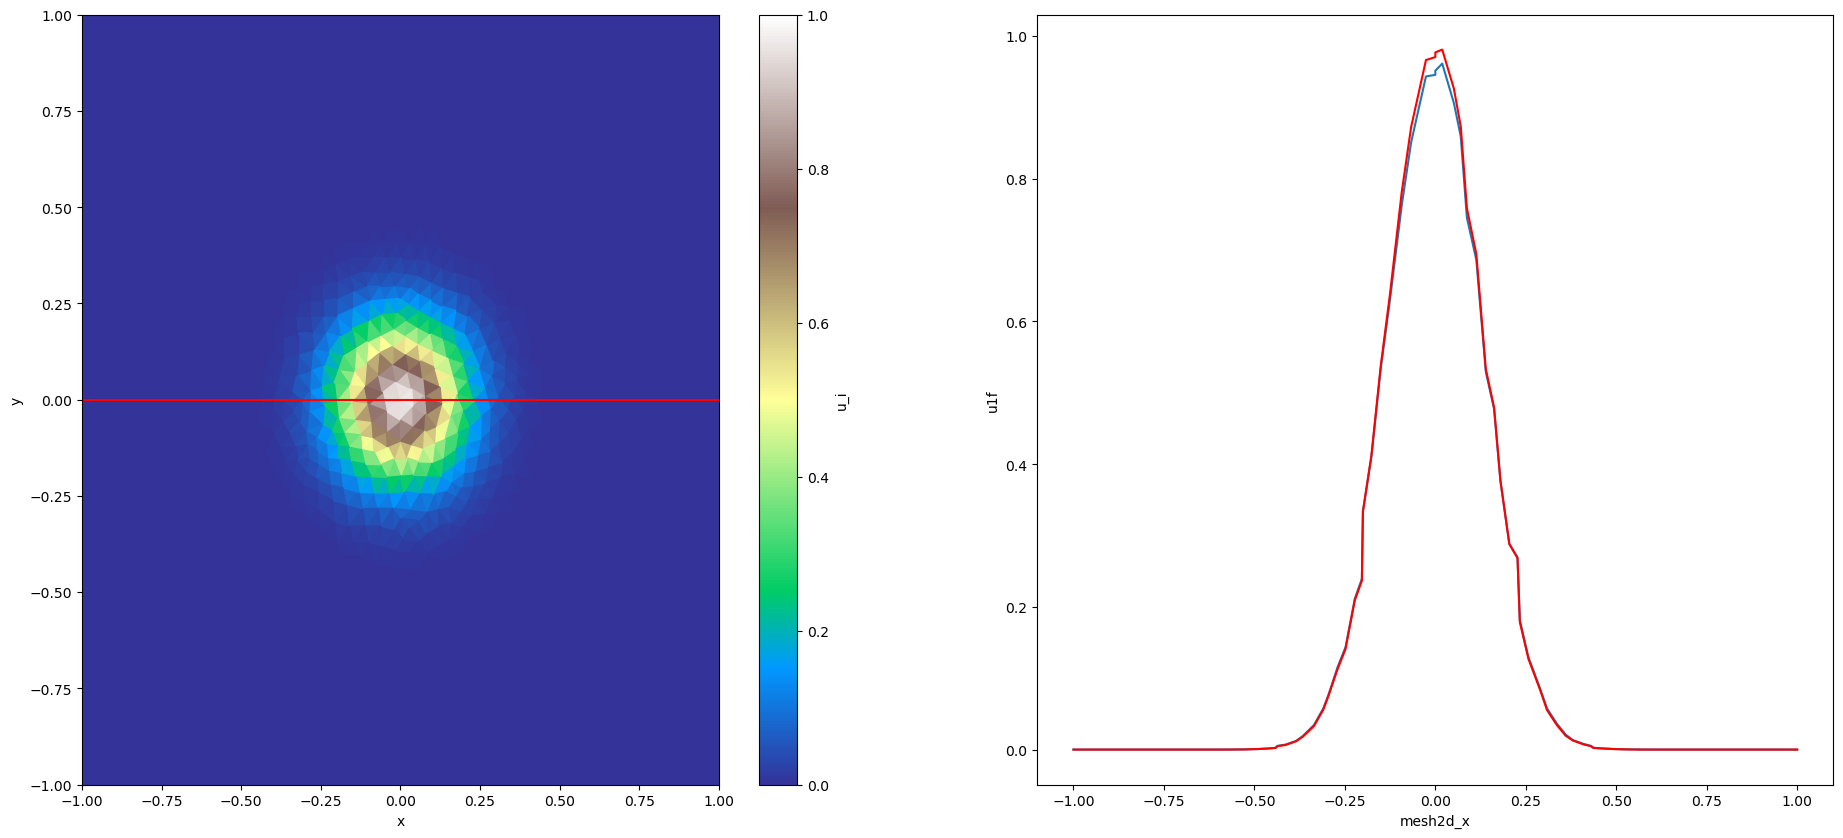

In [12]:
## intersection_area=M.1 or intersection_area=Mf.1
## The intersection area should be the element area, except where there is partial ovelap.
node_ones=np.ones(A_grid.n_node,dtype=np.float64)
face_ones=np.ones(A_grid.n_face,dtype=np.float64)

intersect_area=M*node_ones
intersect_area2=Mf*face_ones

dd=intersect_area-intersect_area2
print("Difference beetween intersection area methods (should be 0.) min: %e max: %e mean: %e" %(dd.min(),dd.max(),dd.mean()))

dd2=B_grid.area-intersect_area
print("Difference between element area and intersection area (should be close to 0.) min: %e max: %e mean: %e" %(dd2.min(),dd2.max(),dd2.mean()))

## Perform the interpolation from the weigths
u_B_f_i=M*u_A_n.values
u_B_f_i=u_B_f_i/intersect_area

u_B_f_i = xr.DataArray(
    data=u_B_f_i,
    name="u_i",
    dims=[B_grid.face_dimension],
    attrs=dict(mesh=B_grid.name,location="face"))
    
u_B_f_i = xu.UgridDataArray(u_B_f_i, B_grid)

### Agrad_face to Bgrad_face
dudx_B_f_i=Mf*dudx_A_f
dudx_B_f_i=dudx_B_f_i/intersect_area2

dudy_B_f_i=Mf*dudy_A_f
dudy_B_f_i=dudy_B_f_i/intersect_area2

# Get a cross-section
section_y = 0.0
section = u_B_f_i.ugrid.sel(y=section_y)

section_ref= u_B_f.ugrid.sel(y=section_y)

# Plot unstructured grid and cross section
fig, (ax0, ax1) = plt.subplots(figsize=(22.6, 10), ncols=2)
u_B_f_i.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
ax0.axhline(y=section_y, color="red")
section.plot(ax=ax1, x="mesh2d_x")
section_ref.plot(ax=ax1, x="mesh2d_x",color="red")

In [13]:
#### Plot MinMax

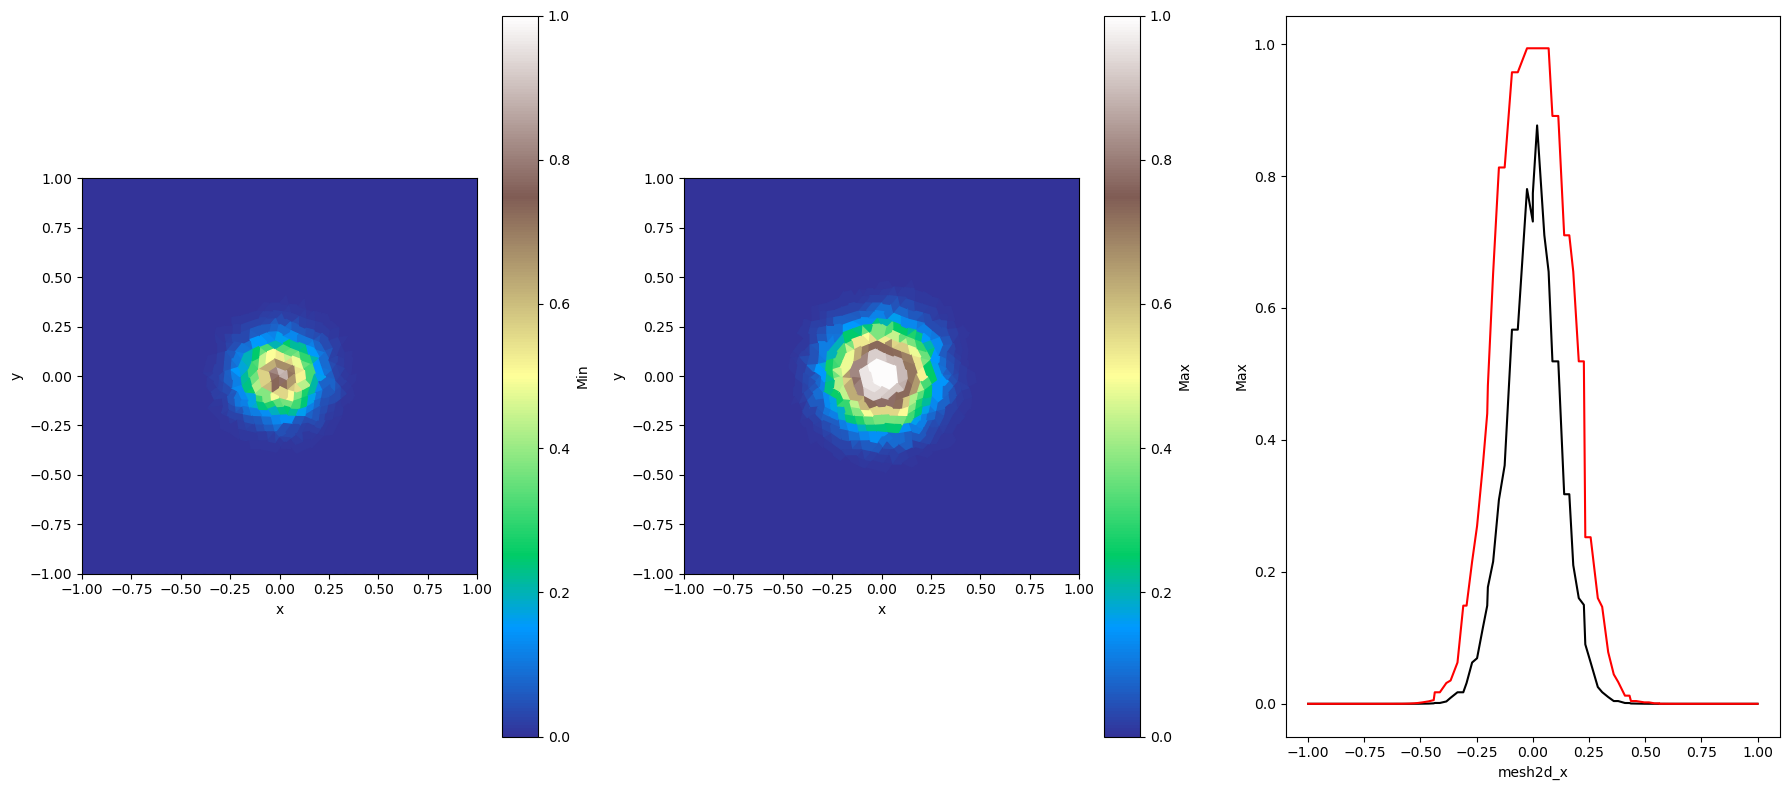

In [14]:
MinVal = xr.DataArray(
    data=MinMax[:,0],
    name="Min",
    dims=[B_grid.face_dimension],
    attrs=dict(mesh=B_grid.name,location="face"))
MinVal = xu.UgridDataArray(MinVal, B_grid)

MaxVal = xr.DataArray(
    data=MinMax[:,1],
    name="Max",
    dims=[B_grid.face_dimension],
    attrs=dict(mesh=B_grid.name,location="face"))
MaxVal = xu.UgridDataArray(MaxVal, B_grid)


section_min= MinVal.ugrid.sel(y=section_y)
section_max= MaxVal.ugrid.sel(y=section_y)


fig, (ax0, ax1 , ax2) = plt.subplots(ncols=3,figsize=(18, 8))
MinVal.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
MaxVal.ugrid.plot(ax=ax1,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)


section_min.plot(ax=ax2, x="mesh2d_x",color="black")
section_max.plot(ax=ax2, x="mesh2d_x",color="red")

fig.tight_layout()


3. Project interpolated values to the nodes

Interpolated values range: 8.756511e-27 9.932639e-01
error min: -6.736053e-03 max: 5.795162e-03 mean: -2.829257e-06


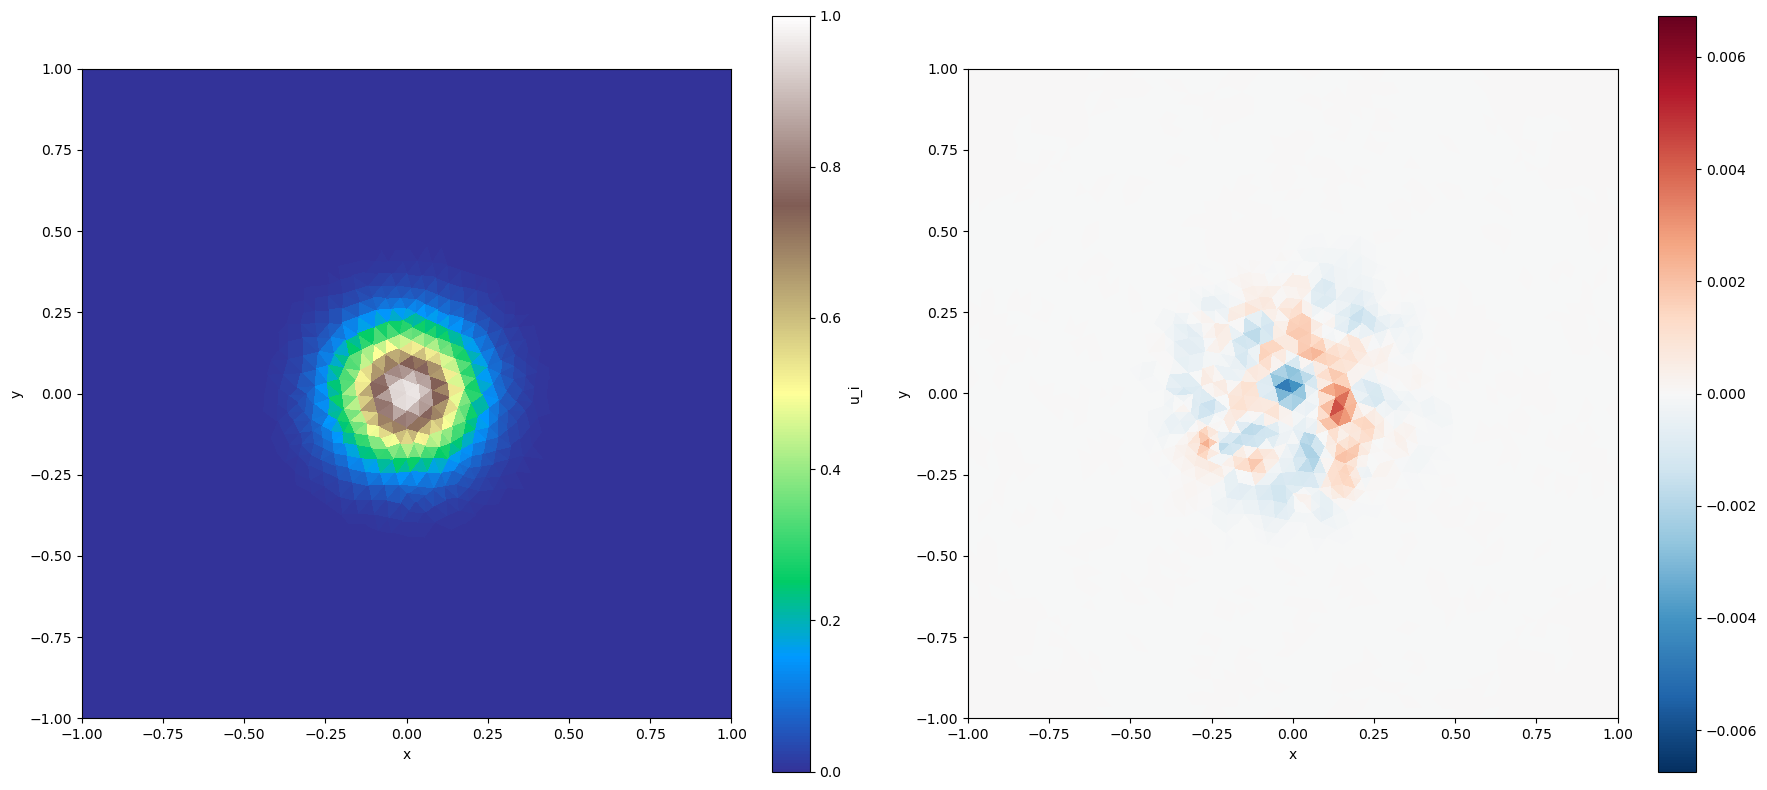

In [15]:
face_values=u_B_f_i.values
grad_values=np.column_stack((dudx_B_f_i,dudy_B_f_i))

bounded=True

if (not bounded):
    u_B_n_i=face_2_node_projection(face_values=face_values,
                               grad_values=grad_values,
                               nn=B_grid.n_node,
                               faces=B_grid.face_node_connectivity,
                               facesx=B_grid.face_coordinates,
                               nodes=B_grid.face_node_coordinates
                               )
else:
    u_B_n_i=face_2_node_projection_bounded(face_values=face_values,
                               grad_values=grad_values,
                               MinMax= MinMax,
                               nn=B_grid.n_node,
                               faces=B_grid.face_node_connectivity,
                               facesx=B_grid.face_coordinates,
                               nodes=B_grid.face_node_coordinates
                               )

u_B_n_i = xr.DataArray(
    data=u_B_n_i,
    name="u_i",
    dims=[B_grid.node_dimension],
    attrs=dict(mesh=B_grid.name,location="node"))
u_B_n_i = xu.UgridDataArray(u_B_n_i, B_grid)

error=u_B_n_i - u_B_n


fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
u_B_n_i.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
error.ugrid.plot(ax=ax1,xlim=(-1.0,1.0),ylim=(-1.0,1.0))
ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)
fig.tight_layout()

print("Interpolated values range: %e %e"%(u_B_n_i.values.min(),u_B_n_i.values.max()))
print("error min: %e max: %e mean: %e"%(error.values.min(),error.values.max(),error.values.mean()))

### Test barycentric interpolation

number of points not found in the mesh 85
Interpolated values range: 8.756511e-27 9.828941e-01
error min: -2.055116e-02 max: 7.209244e-03 mean: 1.541547e-05


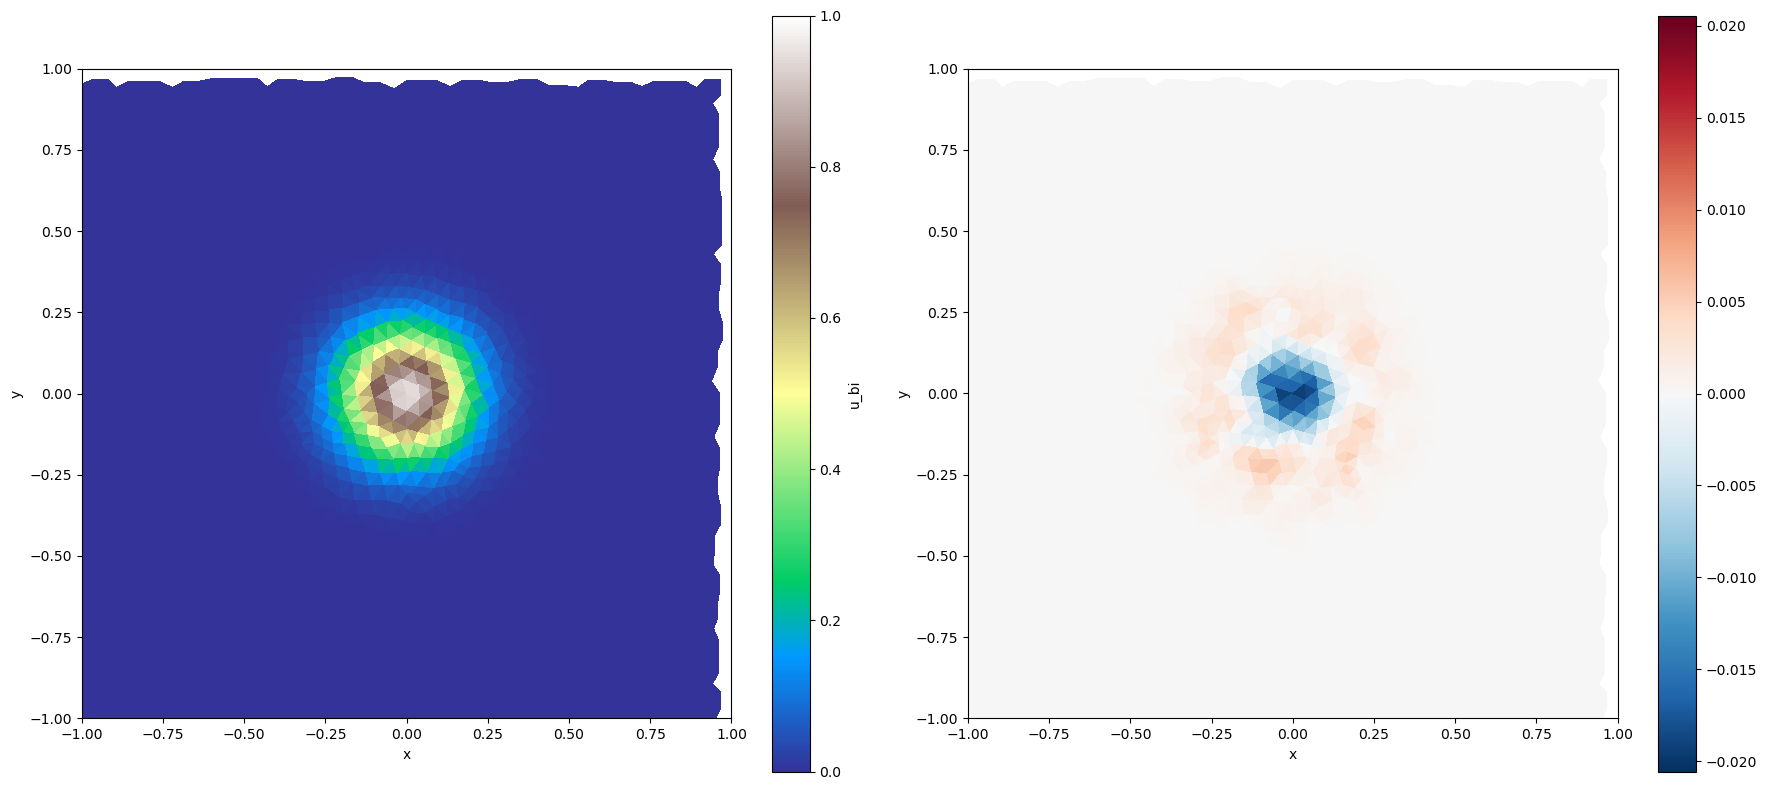

In [16]:
points=B_grid.node_coordinates

M,out = barycentric_interpolator(points, A_grid)
print("number of points not found in the mesh %i"%len(out))
## points on the right and top boundaries are not located in the mesh......

## Do the interpolation
res=M*u_A_n.values

## do something for unfound nodes
default_val=np.nan
#default_val=0.0

res[out]=default_val

u_B_n_bi = xu.UgridDataArray(
                xr.DataArray(
                    data=res,
                    name="u_bi",
                    dims=[B_grid.node_dimension],
                    attrs=dict(mesh=B_grid.name,location="node")),
                B_grid)
                
error2=u_B_n_bi - u_B_n

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
u_B_n_bi.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
error2.ugrid.plot(ax=ax1,xlim=(-1.0,1.0),ylim=(-1.0,1.0))

ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)
fig.tight_layout()

print("Interpolated values range: %e %e"%(np.nanmin(u_B_n_bi.values),np.nanmax(u_B_n_bi.values)))
print("error min: %e max: %e mean: %e"%(np.nanmin(error2.values),np.nanmax(error2.values),np.nanmean(error2.values)))


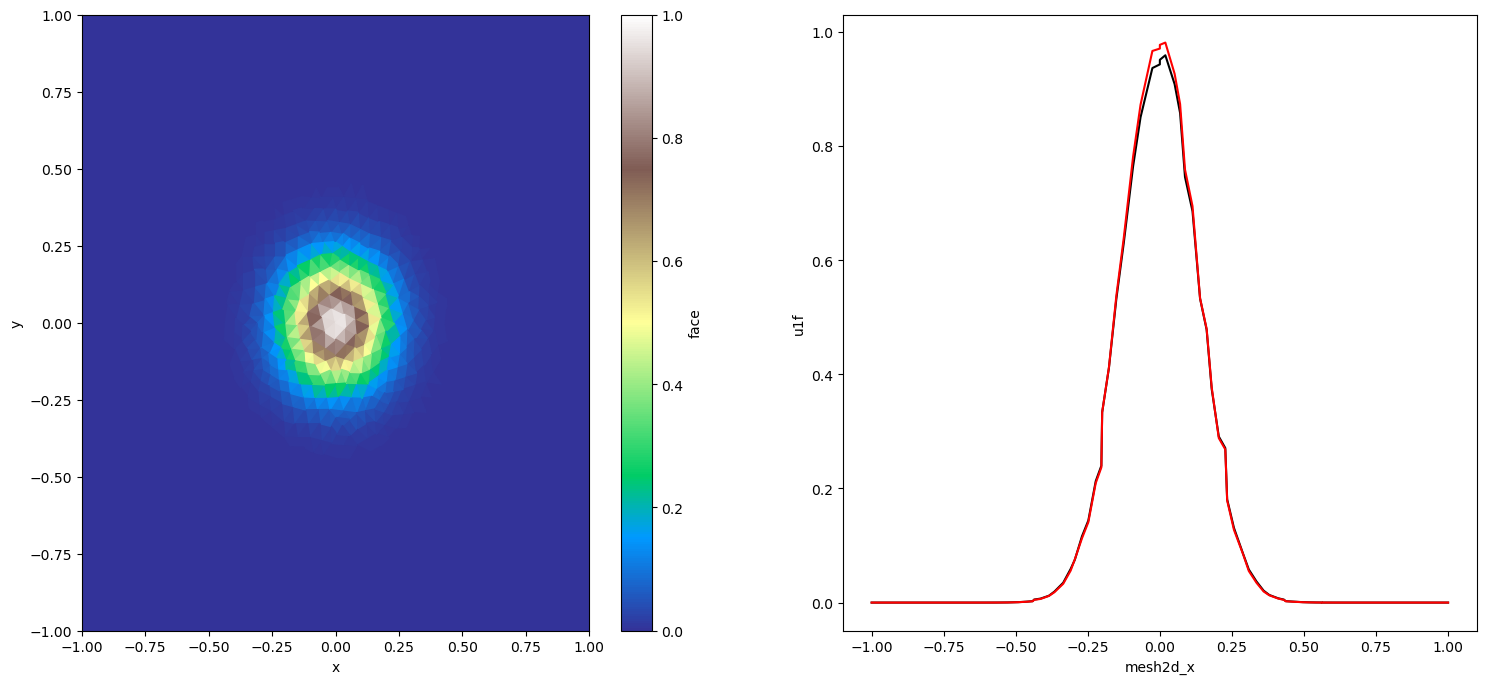

In [17]:
### just to illustrate how we could reproject nodal values to face values;
## it should be conservatove for P1 interpolation

tt=node_2_face_projection(node_values=u_B_n_i.values,faces=u_B_n_i.ugrid.grid.face_node_connectivity)
ttu = xr.DataArray(
    data=tt,
    name="face",
    dims=[B_grid.face_dimension],
    attrs=dict(mesh=B_grid.name,location="face"))
ttu = xu.UgridDataArray(ttu, B_grid)

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
ttu.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))

section_ttu= ttu.ugrid.sel(y=section_y)
section_ttu.plot(ax=ax1, x="mesh2d_x",color="black")
section_ref.plot(ax=ax1, x="mesh2d_x",color="red")


### Validation of the mass conservation

In [18]:
vertices=cast_vertices(B_grid.node_coordinates)
faces=cast_faces(B_grid.face_node_connectivity,B_grid.fill_value)

values=np.ones(B_grid.n_node)
tot_area=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)

print("area should be 2.0*2.0=4.0: %e"%(tot_area))

## integrate solution defined on B
values=u_B_n.values
integral1=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)


## integrate solution interpolated on B
values=u_B_n_i.values
integral2=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)

## integrate the difference
values=u_B_n_i.values-u_B_n.values
diff=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)
diff=np.abs(diff)

## integrate the solution defined on mesh A
verticesA=cast_vertices(A_grid.node_coordinates)
facesA=cast_faces(A_grid.face_node_connectivity,A_grid.fill_value)
values=u_A_n.values
integral_A=TriIntegrate(values=values,
                       faces=facesA,
                       nodes=A_grid.face_node_coordinates)

print("total mass:")
print("solution defined on B: %g"%integral1)
print("solution interpolated on B: %g"%integral2)
print("solution defined on 1: %g"%integral_A)

mass_variation=np.abs(integral2-integral_A)
print("mass error: %e "%(mass_variation))

print("L1 norm error: %g"%(diff))



area should be 2.0*2.0=4.0: 4.000000e+00
total mass:
solution defined on B: 0.104725
solution interpolated on B: 0.104692
solution defined on 1: 0.104692
mass error: 0.000000e+00 
L1 norm error: 3.36391e-05


### Test if we don't apply the gradient for the projection

solution is then simply the wieghted average of the face values

Interpolated values range: 0.000000 0.948388
error min: -0.053447 max: 0.027122 mean: 0.000037


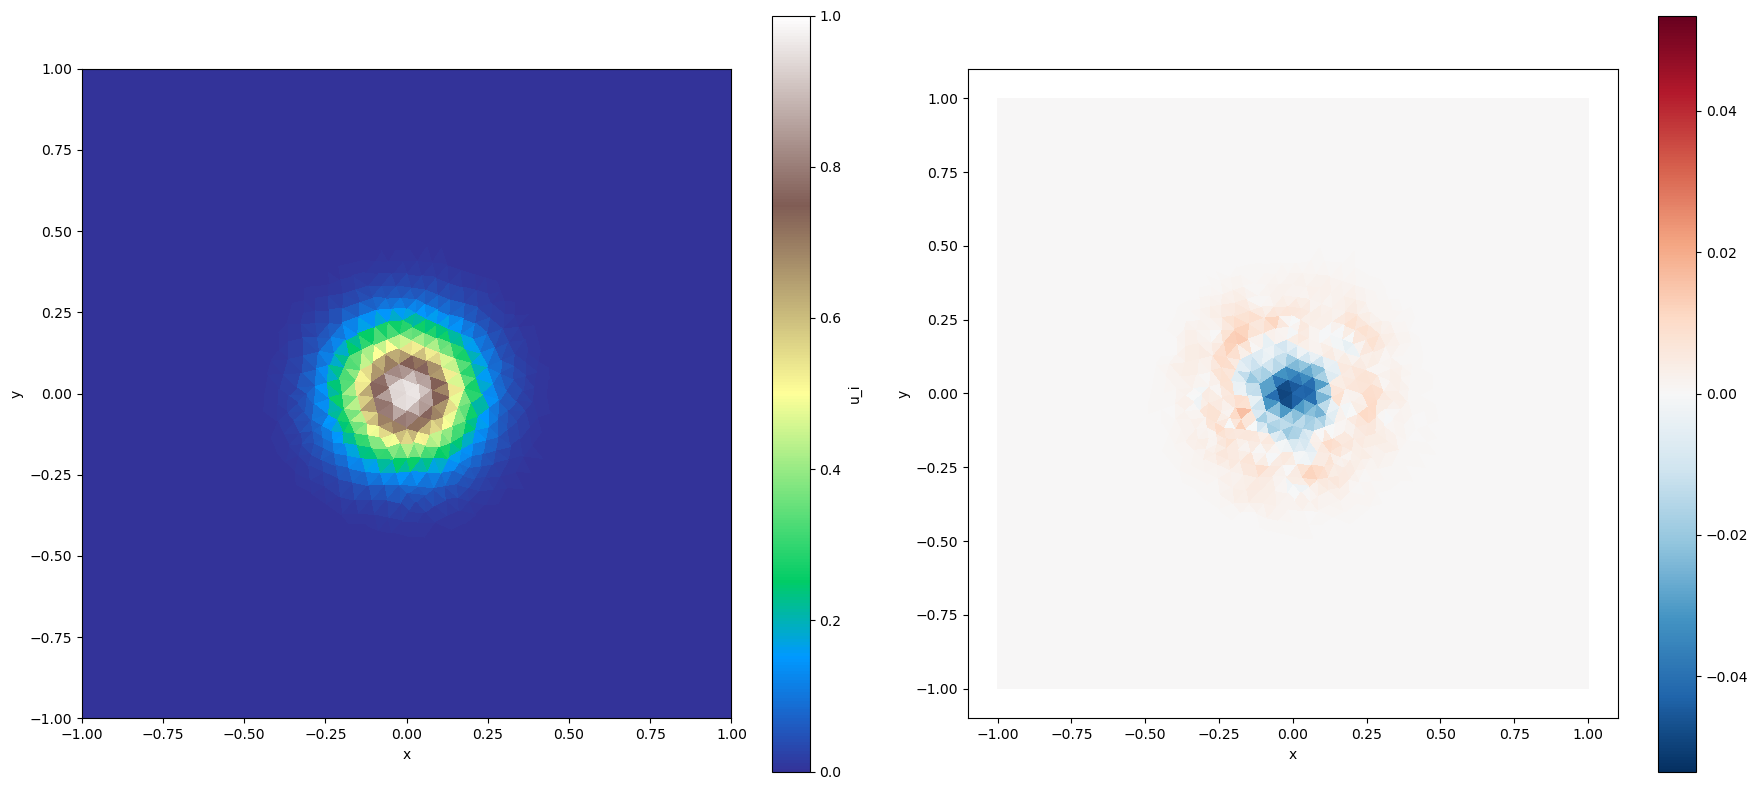

In [19]:
face_values=u_B_f_i.values
zero_values=np.zeros((B_grid.n_face,2))

u_B_n_i2=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=B_grid.n_node,
                               faces=B_grid.face_node_connectivity,
                               facesx=B_grid.face_coordinates,
                               nodes=B_grid.face_node_coordinates
                               )

u_B_n_i2 = xr.DataArray(
    data=u_B_n_i2,
    name="u_i",
    dims=[B_grid.node_dimension],
    attrs=dict(mesh=B_grid.name,location="node"))
u_B_n_i2 = xu.UgridDataArray(u_B_n_i2, B_grid)

error=u_B_n_i2 - u_B_n


fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
u_B_n_i.ugrid.plot(ax=ax0,vmin=0, vmax=1.0, cmap="terrain",xlim=(-1.0,1.0),ylim=(-1.0,1.0))
error.ugrid.plot(ax=ax1)
ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)
fig.tight_layout()

print("Interpolated values range: %f %f"%(u_B_n_i2.values.min(),u_B_n_i2.values.max()))
print("error min: %f max: %f mean: %f"%(error.values.min(),error.values.max(),error.values.mean()))

### Convergence loop

#### The Gaussian function test case

CASE: 1 - A nodes: 676 - B nodes: 602
  - Interpolated values range: 8.756511e-27 9.728012e-01
  - P1 conservatiove interp.: L1 error and mass variation: 1.658475e-04 2.775558e-17
  - Barycentric interp.: L1 error and mass variation: 4.951871e-04 3.293396e-04
CASE: 2 - A nodes: 2613 - B nodes: 2321
  - Interpolated values range: 8.756511e-27 9.932639e-01
  - P1 conservatiove interp.: L1 error and mass variation: 3.363913e-05 0.000000e+00
  - Barycentric interp.: L1 error and mass variation: 5.255962e-05 1.892049e-05
CASE: 3 - A nodes: 10273 - B nodes: 9113
  - Interpolated values range: 8.756511e-27 9.958388e-01
  - P1 conservatiove interp.: L1 error and mass variation: 7.977165e-06 1.665335e-16
  - Barycentric interp.: L1 error and mass variation: 1.092848e-05 2.951315e-06
CASE: 4 - A nodes: 40737 - B nodes: 36113
  - Interpolated values range: 8.756511e-27 9.997349e-01
  - P1 conservatiove interp.: L1 error and mass variation: 1.967982e-06 3.747003e-16
  - Barycentric interp.: L1 err

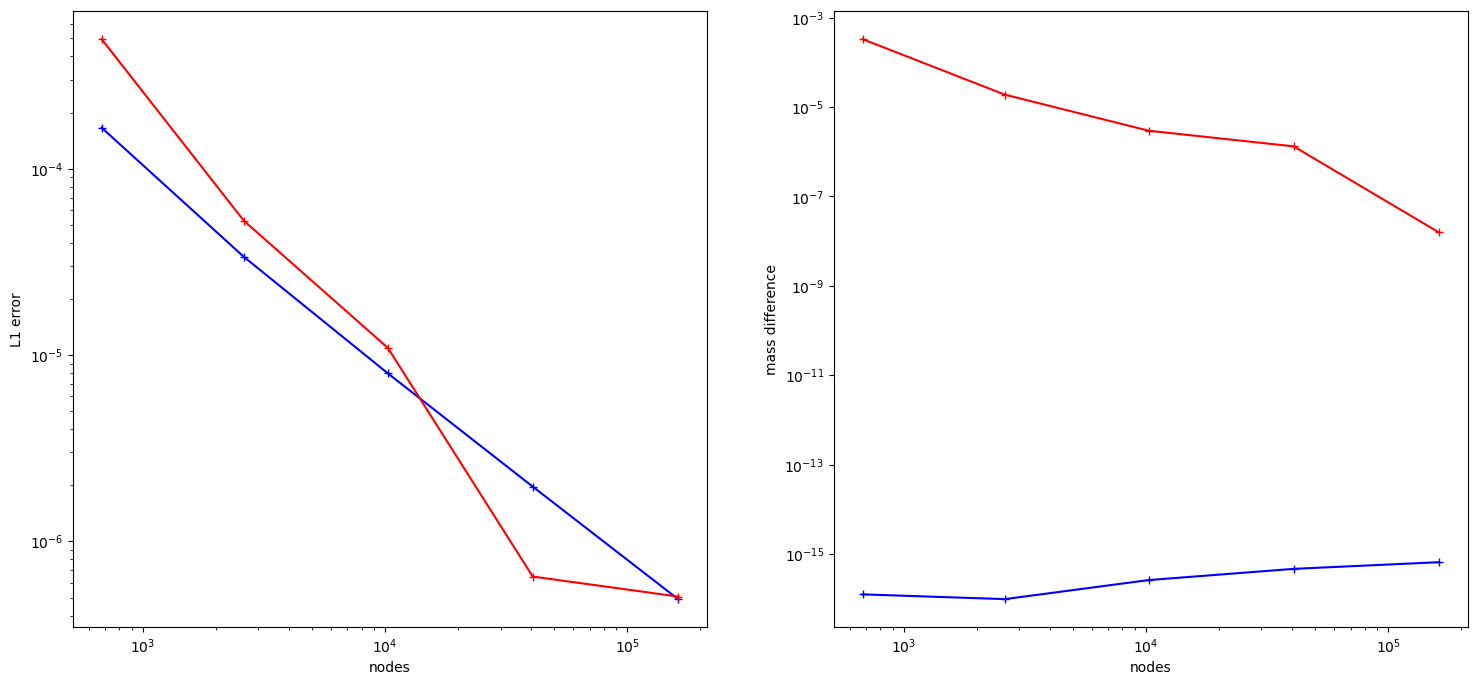

In [20]:
bounded=True

nmax=5
nodes=np.zeros(nmax,dtype=np.int32)
err=np.zeros((nmax,4),dtype=np.float64)

for case in range(1,nmax+1):
    
    mesh_name="squareA%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    A_grid=xu.Ugrid2d.FromElmer(mesh_name)

    mesh_name="squareB%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    B_grid=xu.Ugrid2d.FromElmer(mesh_name)

    print("CASE: %i - A nodes: %i - B nodes: %i"%(case,A_grid.n_node,B_grid.n_node))

    ## define function value at nodes
    u_A_n=u1(A_grid)
    u_B_n=u1(B_grid)

    
    ## P1-Conservative interpolation in 1 function:
    u_B_n_i = node_2_node_interpolation(u_A_n,B_grid,bounded)

    print("  - Interpolated values range: %e %e"%(u_B_n_i.values.min(),u_B_n_i.values.max()))

    error=u_B_n_i - u_B_n

    vertices=cast_vertices(B_grid.node_coordinates)
    faces=cast_faces(B_grid.face_node_connectivity,B_grid.fill_value)
    
    values=error.values
    diff=TriIntegrate(values=values,
                     faces=faces,
                      nodes=B_grid.face_node_coordinates)
    diff=np.abs(diff)

    values=u_B_n_i.values
    integral2=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)
    ##
    verticesA=cast_vertices(A_grid.node_coordinates)
    facesA=cast_faces(A_grid.face_node_connectivity,A_grid.fill_value)
    values=u_A_n.values
    integral_A=TriIntegrate(values=values,
                       faces=facesA,
                       nodes=A_grid.face_node_coordinates)
    
    mass_variation=np.abs(integral2-integral_A)
    
    print("  - P1 conservatiove interp.: L1 error and mass variation: %e %e"%(diff,mass_variation))

    #####################################################################
    ## Barycentric interpolation
    #####################################################################"
    M,out = barycentric_interpolator(B_grid.node_coordinates, A_grid)
    res=M*u_A_n.values
    ## do something for unfound nodes; here issues are with points on the right and top bounaries so value should be 0...
    default_val=0.0
    res[out]=default_val

    u_B_n_bi = xu.UgridDataArray(
                xr.DataArray(
                    data=res,
                    name="u_bi",
                    dims=[B_grid.node_dimension],
                    attrs=dict(mesh=B_grid.name,location="node")),
                B_grid)
                
    errorbi=u_B_n_bi - u_B_n
    diffbi=TriIntegrate(values=errorbi.values,
                       faces=faces,
                        nodes=B_grid.face_node_coordinates)
    diffbi=np.abs(diffbi)
 
    integralbi=TriIntegrate(values=u_B_n_bi.values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)

    mass_variationbi=np.abs(integralbi-integral_A)

    print("  - Barycentric interp.: L1 error and mass variation: %e %e"%(diffbi,mass_variationbi))



    nodes[case-1]=A_grid.n_node
    err[case-1,0]=diff
    err[case-1,1]=mass_variation
    err[case-1,2]=diffbi
    err[case-1,3]=mass_variationbi

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
ax0.loglog(nodes,err[:,0],marker='+',color="blue")
ax0.loglog(nodes,err[:,2],marker='+',color="red")
ax1.loglog(nodes,err[:,1]+1.0e-16,marker='+',color="blue")
ax1.loglog(nodes,err[:,3]+1.0e-16,marker='+',color="red")

ax0.set_xlabel('nodes')
ax0.set_ylabel('L1 error')

ax1.set_xlabel('nodes')
ax1.set_ylabel('mass difference')

error_bounded=err

CASE: 1 - A nodes: 676 - B nodes: 602
  - Interpolated values range: -2.718529e-04 9.735608e-01
  - L1 error and mass variation: 1.658475e-04 1.387779e-17
CASE: 2 - A nodes: 2613 - B nodes: 2321
  - Interpolated values range: -1.539390e-10 9.964891e-01
  - L1 error and mass variation: 3.363913e-05 0.000000e+00
CASE: 3 - A nodes: 10273 - B nodes: 9113
  - Interpolated values range: -1.536931e-24 9.997140e-01
  - L1 error and mass variation: 7.977165e-06 2.220446e-16
CASE: 4 - A nodes: 40737 - B nodes: 36113
  - Interpolated values range: 8.402316e-27 9.997450e-01
  - L1 error and mass variation: 1.967982e-06 3.191891e-16
CASE: 5 - A nodes: 162241 - B nodes: 143777
  - Interpolated values range: 8.699939e-27 9.999529e-01
  - L1 error and mass variation: 4.903622e-07 5.134781e-16


Text(0, 0.5, 'mass difference')

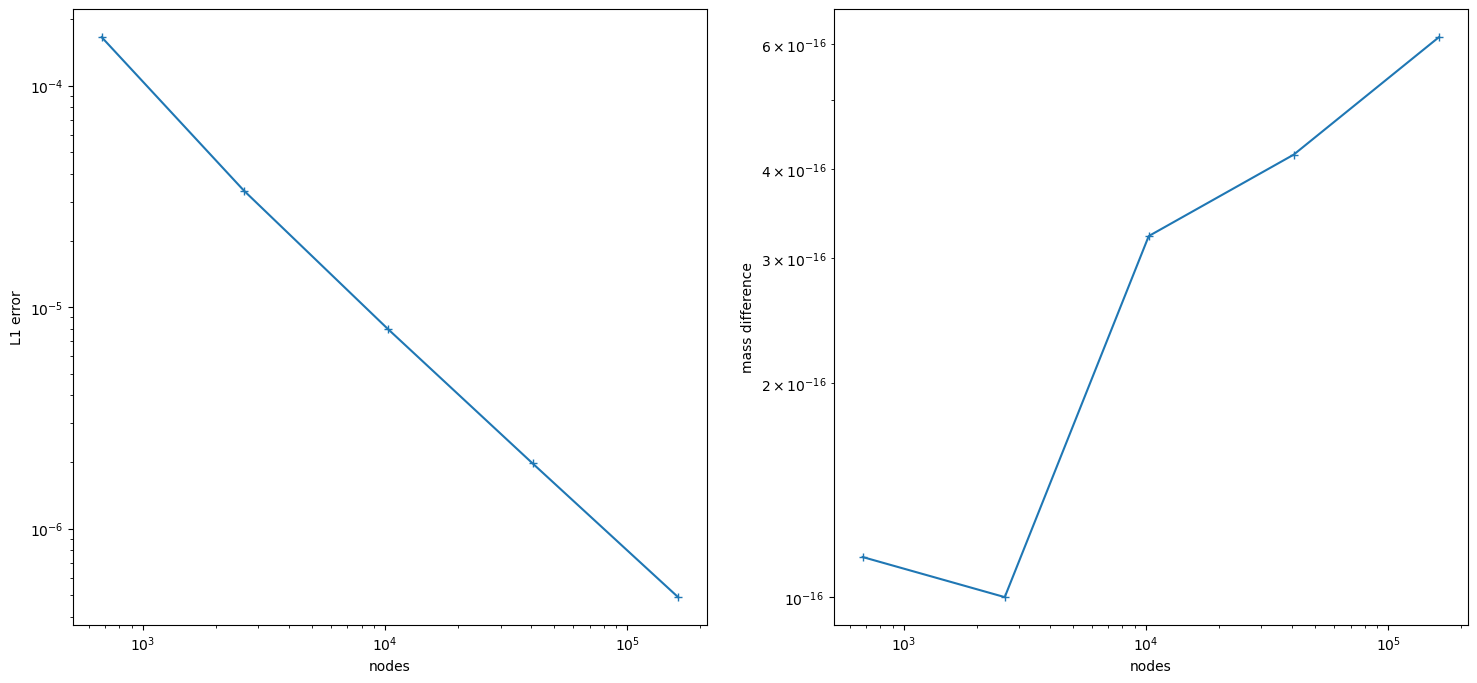

In [21]:
bounded=False

nmax=5
nodes=np.zeros(nmax,dtype=np.int32)
err=np.zeros((nmax,2),dtype=np.float64)

for case in range(1,nmax+1):
    
    mesh_name="squareA%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    A_grid=xu.Ugrid2d.FromElmer(mesh_name)

    mesh_name="squareB%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    B_grid=xu.Ugrid2d.FromElmer(mesh_name)

    print("CASE: %i - A nodes: %i - B nodes: %i"%(case,A_grid.n_node,B_grid.n_node))

    ## define function value at nodes
    u_A_n=u1(A_grid)
    u_B_n=u1(B_grid)

    u_B_n_i = node_2_node_interpolation(u_A_n,B_grid,bounded)

    print("  - Interpolated values range: %e %e"%(u_B_n_i.values.min(),u_B_n_i.values.max()))

    error=u_B_n_i - u_B_n

    vertices=cast_vertices(B_grid.node_coordinates)
    faces=cast_faces(B_grid.face_node_connectivity,B_grid.fill_value)
    
    values=error.values
    diff=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)
    diff=np.abs(diff)

    values=u_B_n_i.values
    integral2=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)
    ##
    verticesA=cast_vertices(A_grid.node_coordinates)
    facesA=cast_faces(A_grid.face_node_connectivity,A_grid.fill_value)
    values=u_A_n.values
    integral_A=TriIntegrate(values=values,
                       faces=facesA,
                       nodes=A_grid.face_node_coordinates)
    
    mass_variation=np.abs(integral2-integral_A)
    
    print("  - L1 error and mass variation: %e %e"%(diff,mass_variation))

    nodes[case-1]=A_grid.n_node
    err[case-1,0]=diff
    err[case-1,1]=mass_variation

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
ax0.loglog(nodes,err[:,0],marker='+')
ax1.loglog(nodes,err[:,1]+1.0e-16,marker='+')

ax0.set_xlabel('nodes')
ax0.set_ylabel('L1 error')

ax1.set_xlabel('nodes')
ax1.set_ylabel('mass difference')

Text(0, 0.5, 'mass difference')

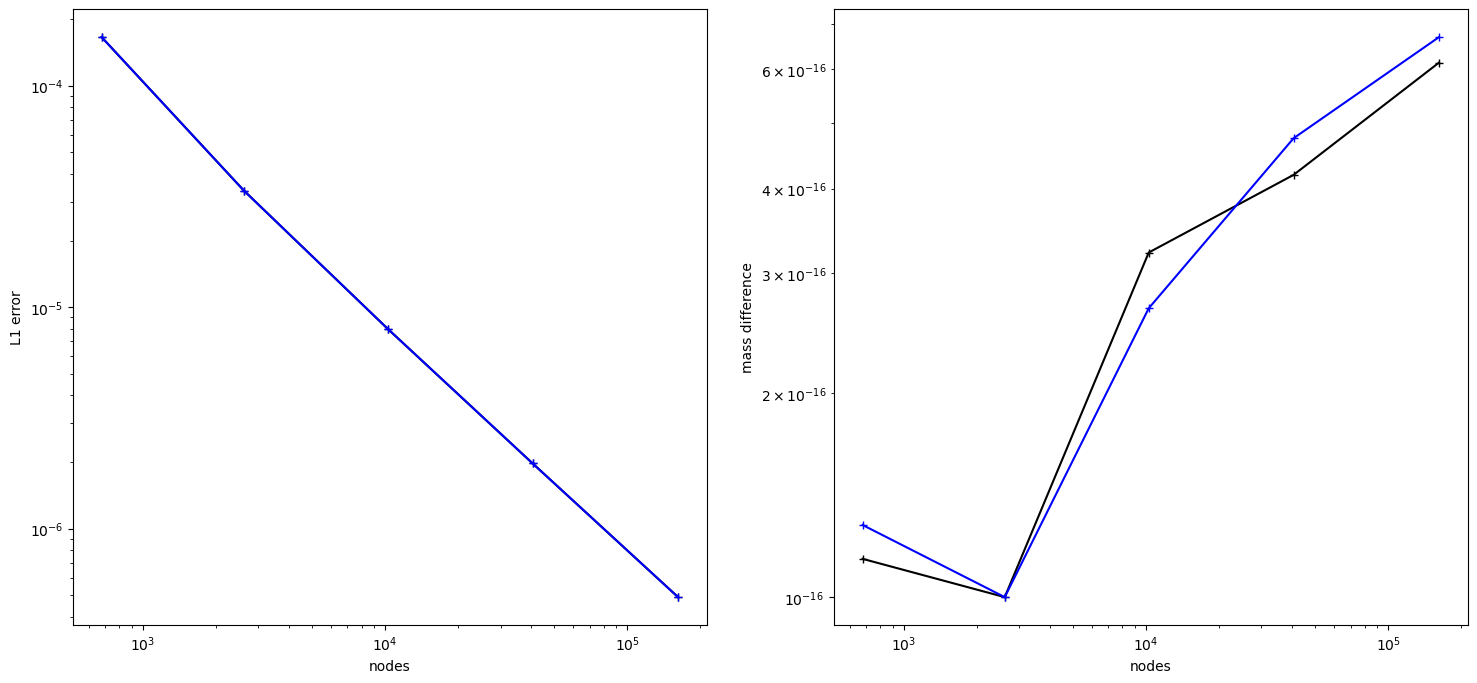

In [22]:
## Compare bounded and unbounded solutions
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
ax0.loglog(nodes,err[:,0],marker='+',color="black")
ax0.loglog(nodes,error_bounded[:,0],marker='+',color="blue")
ax1.loglog(nodes,err[:,1]+1.0e-16,marker='+',color="black")
ax1.loglog(nodes,error_bounded[:,1]+1.0e-16,marker='+',color="blue")

ax0.set_xlabel('nodes')
ax0.set_ylabel('L1 error')

ax1.set_xlabel('nodes')
ax1.set_ylabel('mass difference')

#### Sinusoidal shock test case

CASE: 1 - A nodes: 676 - B nodes: 602
  - Interpolated values range: -1.000000e+00 1.000000e+00
  - L1 error and mass variation: 1.080114e-03 1.127570e-17
CASE: 2 - A nodes: 2613 - B nodes: 2321
  - Interpolated values range: -1.000000e+00 1.000000e+00
  - L1 error and mass variation: 3.677840e-03 2.081668e-17
CASE: 3 - A nodes: 10273 - B nodes: 9113
  - Interpolated values range: -1.000000e+00 1.000000e+00
  - L1 error and mass variation: 5.312955e-04 5.702903e-17
CASE: 4 - A nodes: 40737 - B nodes: 36113
  - Interpolated values range: -1.000000e+00 1.000000e+00
  - L1 error and mass variation: 8.989552e-05 7.116703e-16
CASE: 5 - A nodes: 162241 - B nodes: 143777
  - Interpolated values range: -1.000000e+00 1.000000e+00
  - L1 error and mass variation: 2.260672e-05 1.483405e-15


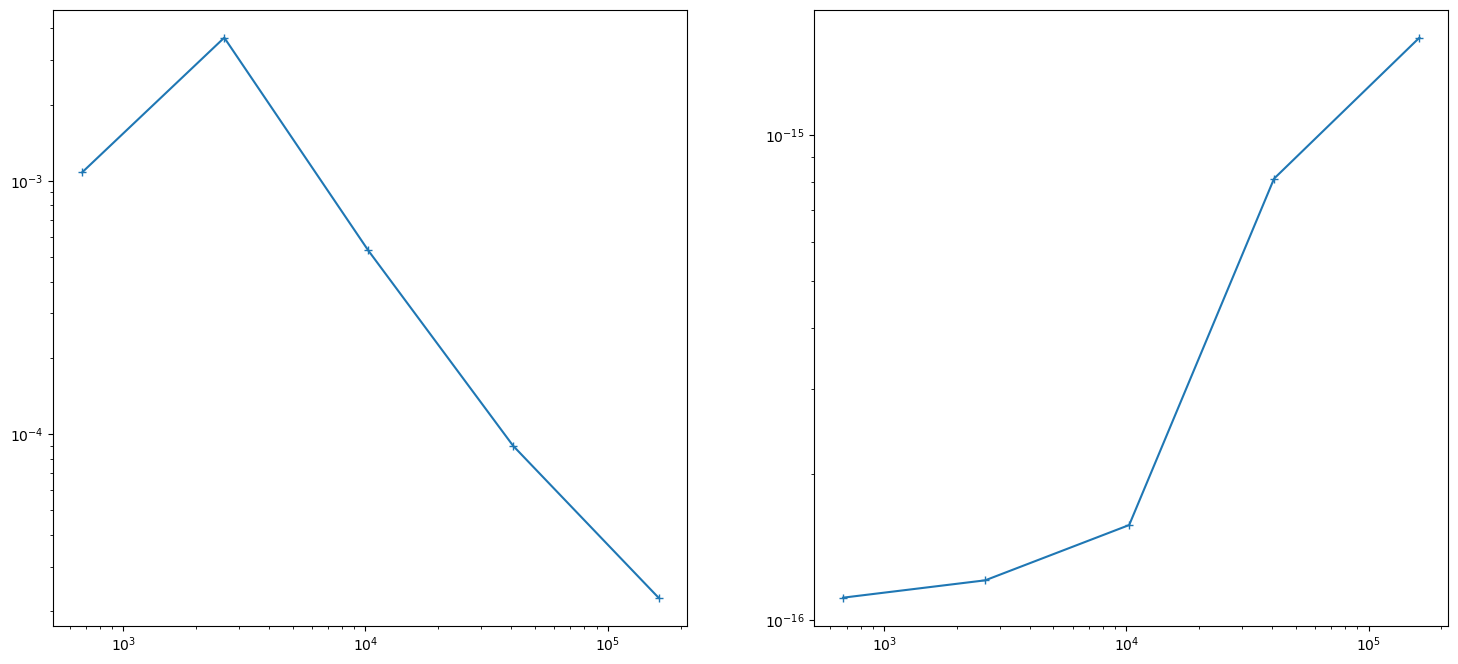

In [23]:
bounded=True

nmax=5
nodes=np.zeros(nmax,dtype=np.int32)
err=np.zeros((nmax,2),dtype=np.float64)

for case in range(1,nmax+1):
    
    mesh_name="squareA%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    A_grid=xu.Ugrid2d.FromElmer(mesh_name)

    mesh_name="squareB%s"%(str(case))
    mesh_name=os.path.join(DATA_DIR, mesh_name)
    B_grid=xu.Ugrid2d.FromElmer(mesh_name)

    print("CASE: %i - A nodes: %i - B nodes: %i"%(case,A_grid.n_node,B_grid.n_node))

    ## define function value at nodes
    u_A_n=u2(A_grid)
    u_B_n=u2(B_grid)

    ## P1-Conservative interpolation in 1 function:
    u_B_n_i = node_2_node_interpolation(u_A_n,B_grid,bounded)


    print("  - Interpolated values range: %e %e"%(u_B_n_i.values.min(),u_B_n_i.values.max()))

    error=u_B_n_i - u_B_n

    vertices=cast_vertices(B_grid.node_coordinates)
    faces=cast_faces(B_grid.face_node_connectivity,B_grid.fill_value)
    
    values=error.values
    diff=TriIntegrate(values=values,
                     faces=faces,
                      nodes=B_grid.face_node_coordinates)
    diff=np.abs(diff)

    values=u_B_n_i.values
    integral2=TriIntegrate(values=values,
                      faces=faces,
                      nodes=B_grid.face_node_coordinates)
    ##
    verticesA=cast_vertices(A_grid.node_coordinates)
    facesA=cast_faces(A_grid.face_node_connectivity,A_grid.fill_value)
    values=u_A_n.values
    integral_A=TriIntegrate(values=values,
                       faces=facesA,
                       nodes=A_grid.face_node_coordinates)
    
    mass_variation=np.abs(integral2-integral_A)
    
    print("  - L1 error and mass variation: %e %e"%(diff,mass_variation))

    nodes[case-1]=A_grid.n_node
    err[case-1,0]=diff
    err[case-1,1]=mass_variation

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))
ax0.loglog(nodes,err[:,0],marker='+')
ax1.loglog(nodes,err[:,1]+1.0e-16,marker='+')


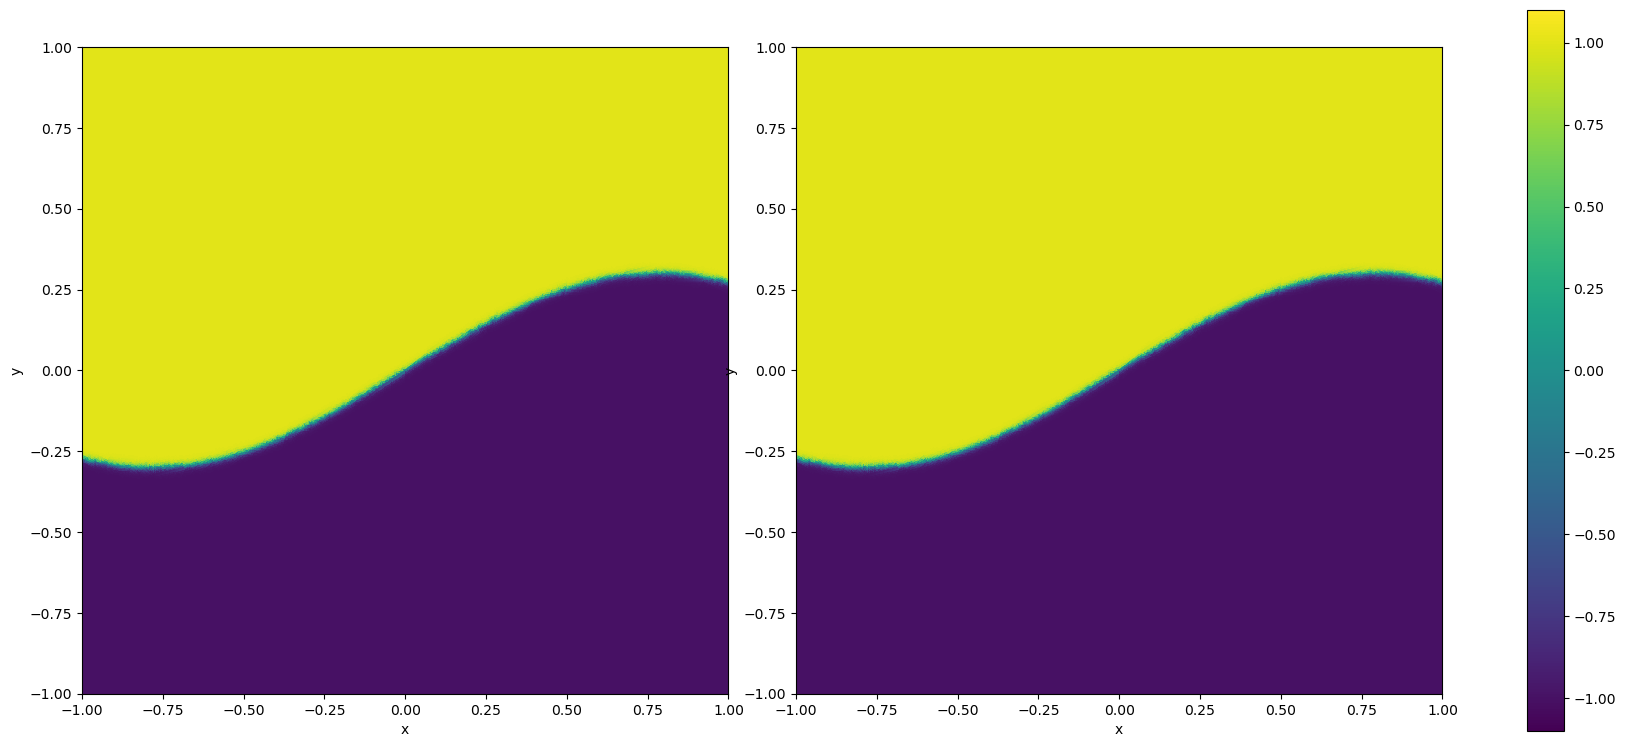

In [24]:
# Plot unstructured grid and cross section
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(18, 8))

im1=u_B_n.ugrid.plot(ax=ax0,vmin=-1.1, vmax=1.1, cmap="viridis",xlim=(-1.0,1.0),ylim=(-1.0,1.0),add_colorbar=False)
im2=u_B_n_i.ugrid.plot(ax=ax1,vmin=-1.1, vmax=1.1, cmap="viridis",xlim=(-1.0,1.0),ylim=(-1.0,1.0),add_colorbar=False)

ax0.set_box_aspect(aspect=1)
ax1.set_box_aspect(aspect=1)
fig.tight_layout()

cb = fig.colorbar(im2, ax=(ax0, ax1), orientation='vertical')